# Statistical Methods Project: Modeling Wrestler Scores
**Student :** Mobin Ghorbani  
**Course :** Statistical Methods  
**Topic :** Bayesian Modeling of Hassan Yazdani’s Wrestling Scores  

**Objective.**  
Analyse and model the average score of Hassan Yazdani in international matches (2015 – 2022) using both *frequentist* and *Bayesian* approaches, culminating in a Gibbs-sampling mixture model for latent “fitness” states.

---


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_theme(context="talk", style="whitegrid")
rng = np.random.default_rng(42)


## Data (2015 – 2021)
The vector `scores` contains Hassan Yazdani’s match scores from 2015 through 2021.


In [3]:
scores = np.array([
    3, 9, 6, 6, 16, 6, 8, 10, 9, 12, 10, 9, 13, 6, 10, 7, 10, 4, 11, 11,
    10, 4, 10, 10, 12, 10, 13, 12, 10, 12, 11, 10, 11, 10, 10, 6, 16, 11, 11, 10,
    10, 11, 5, 11, 5, 9, 10, 10, 10, 10, 3, 7, 12, 11, 6, 8, 10, 12
])
n = len(scores)
print(f"Sample size n = {n}")


Sample size n = 58


## Step 1 – Frequentist Estimates of $\mu$ and $\sigma^{2}$  
We estimate  
\[
\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} y_i,
\qquad
\hat{\sigma}^2 = \frac{1}{n - 1} \sum_{i=1}^{n} (y_i - \hat{\mu})^2
\]


In [4]:
mu_hat     = scores.mean()
sigma2_hat = scores.var(ddof=0)           
sigma_hat  = np.sqrt(sigma2_hat)

print(f"μ̂ (mean)     = {mu_hat:.6f}")
print(f"σ̂² (variance) = {sigma2_hat:.6f}")


μ̂ (mean)     = 9.396552
σ̂² (variance) = 7.722057


### Prior-predictive distribution  
Treat the frequentist estimates as an **informative prior** and sample  

$\tilde{y} \sim \mathcal N(\hat\mu, \hat\sigma^{2})$  

to visualise uncertainty before seeing any new seasons.


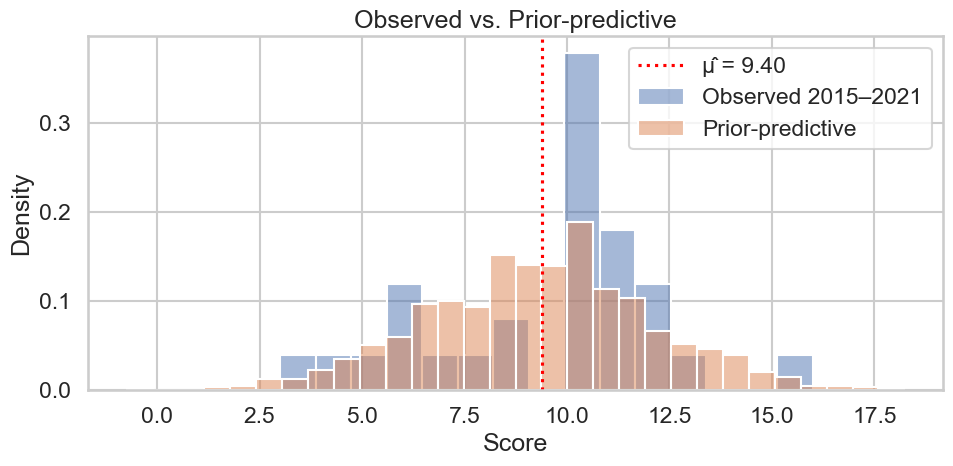

In [5]:
prior_pred = rng.normal(loc=mu_hat, scale=sigma_hat, size=1_000)

plt.figure(figsize=(10,5))
sns.histplot(scores,     bins=15, stat="density", alpha=0.5, label="Observed 2015–2021")
sns.histplot(prior_pred, bins=30, stat="density", alpha=0.5, label="Prior-predictive")
plt.axvline(mu_hat, color="red", ls=":", label=f"μ̂ = {mu_hat:.2f}")
plt.xlabel("Score"); plt.ylabel("Density"); plt.legend()
plt.title("Observed vs. Prior-predictive")
plt.tight_layout(); plt.show()


## Step 2 – Bayesian Update with 2022 Data
Scores recorded in 2022:


In [6]:
new_scores = np.array([11, 12, 12, 1, 10, 11, 10])
lambda_obs = 8.4                   
n_new      = len(new_scores)

post_var   = 1 / (n_new / lambda_obs + 1 / sigma2_hat)
post_mu    = post_var * (new_scores.sum() / lambda_obs + mu_hat / sigma2_hat)
post_sigma = np.sqrt(post_var)

print(f"Posterior μ  = {post_mu:.3f}")
print(f"Posterior σ² = {post_var:.3f}")


Posterior μ  = 9.548
Posterior σ² = 1.039


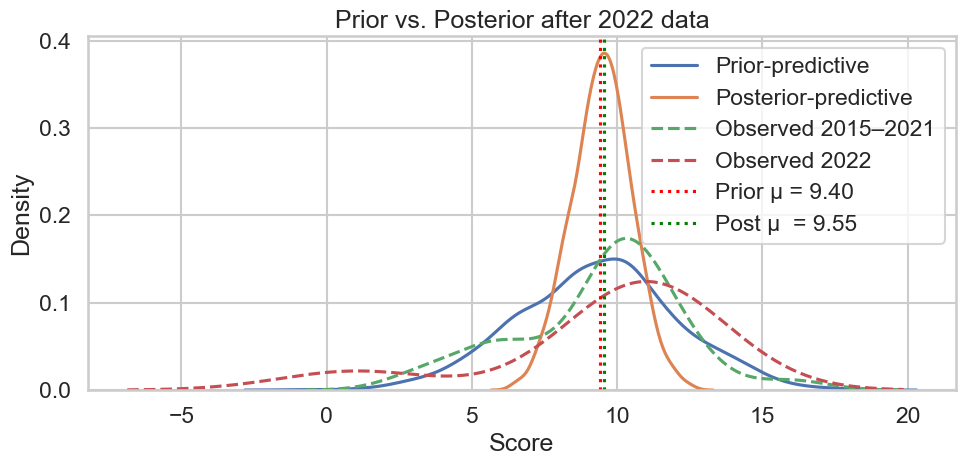

In [7]:
# %%
post_pred = rng.normal(loc=post_mu, scale=post_sigma, size=1_000)

plt.figure(figsize=(10,5))
sns.kdeplot(prior_pred, label="Prior-predictive")
sns.kdeplot(post_pred,  label="Posterior-predictive")
sns.kdeplot(scores,     label="Observed 2015–2021", ls="--")
sns.kdeplot(new_scores, label="Observed 2022",      ls="--")
plt.axvline(mu_hat,  color="red",   ls=":", label=f"Prior μ = {mu_hat:.2f}")
plt.axvline(post_mu, color="green", ls=":", label=f"Post μ  = {post_mu:.2f}")
plt.xlabel("Score"); plt.ylabel("Density"); plt.legend()
plt.title("Prior vs. Posterior after 2022 data")
plt.tight_layout(); plt.show()


## Step 3 – Fitness-based Mixture Model (Known $Z_i$)

We hypothesise two latent fitness states  

* **Well-prepared** ($Z_i=1$) with mean $\theta_1$  
* **Not well-prepared** ($Z_i=0$) with mean $\theta_0$  

Label the top 10 % of historical scores as $Z=1$ (well-prepared) to obtain empirical priors.


In [ ]:

p               = 0.9                    
threshold_index = int(p * n)
sorted_scores   = np.sort(scores)
mu1_prior       = sorted_scores[threshold_index:].mean()  
mu0_prior       = sorted_scores[:threshold_index].mean()  
sigma2_shared   = scores.var(ddof=0)

print(f"μ₁ prior (well-prepared)     = {mu1_prior:.3f}")
print(f"μ₀ prior (not well-prepared) = {mu0_prior:.3f}")
print(f"Shared σ² prior              = {sigma2_shared:.3f}")


μ₁ prior (well-prepared)     = 13.667
μ₀ prior (not well-prepared) = 8.904
Shared σ² prior              = 7.722


### Posterior of $\theta_0$ and $\theta_1$ given **known** $Z$


In [ ]:

Z_known = np.array([1, 1, 1, 0, 1, 1, 1]) 
Y1 = new_scores[Z_known == 1]
Y0 = new_scores[Z_known == 0]

def posterior_normal(Y, mu_prior, sigma2_prior, lambda_obs):
    n = len(Y)
    if n == 0:                         
        return mu_prior, sigma2_prior
    post_var  = 1 / (n / lambda_obs + 1 / sigma2_prior)
    post_mean = post_var * (Y.sum() / lambda_obs + mu_prior / sigma2_prior)
    return post_mean, post_var

theta1_mu, theta1_var = posterior_normal(Y1, mu1_prior, sigma2_shared, lambda_obs)
theta0_mu, theta0_var = posterior_normal(Y0, mu0_prior, sigma2_shared, lambda_obs)

theta1_samps = rng.normal(theta1_mu, np.sqrt(theta1_var), 1_000)
theta0_samps = rng.normal(theta0_mu, np.sqrt(theta0_var), 1_000)

print(f"θ₁ | Z=1 ~ N({theta1_mu:.2f}, {theta1_var:.2f})")
print(f"θ₀ | Z=0 ~ N({theta0_mu:.2f}, {theta0_var:.2f})")


θ₁ | Z=1 ~ N(11.41, 1.19)
θ₀ | Z=0 ~ N(5.12, 4.02)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15036\1156208754.py:6: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15036\1156208754.py:6: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


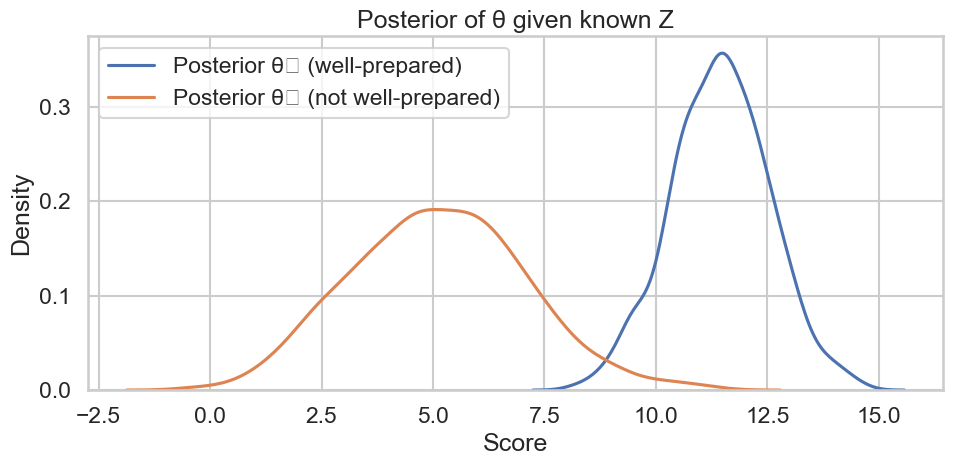

In [ ]:

plt.figure(figsize=(10,5))
sns.kdeplot(theta1_samps, label="Posterior θ₁ (well-prepared)")
sns.kdeplot(theta0_samps, label="Posterior θ₀ (not well-prepared)")
plt.xlabel("Score"); plt.ylabel("Density"); plt.title("Posterior of θ given known Z")
plt.legend(); plt.tight_layout(); plt.show()


## Step 4 – Gibbs Sampling (Unknown $Z_i$)

We now treat the latent states $Z_i$ for 2022 as **unknown** and run a Gibbs sampler:

1. Sample $Z_i \mid \theta_0,\theta_1$  
2. Sample $\theta_0 \mid Z$  
3. Sample $\theta_1 \mid Z$


In [11]:

iterations = 1_000
p_mixture  = 0.9               

Z      = rng.binomial(1, p_mixture, size=len(new_scores))
theta0 = mu0_prior
theta1 = mu1_prior

theta0_chain, theta1_chain = [], []

for _ in range(iterations):
    pdf1 = stats.norm.pdf(new_scores, loc=theta1, scale=np.sqrt(lambda_obs)) * p_mixture
    pdf0 = stats.norm.pdf(new_scores, loc=theta0, scale=np.sqrt(lambda_obs)) * (1 - p_mixture)
    Z    = rng.binomial(1, pdf1 / (pdf1 + pdf0))

    theta0_mu, theta0_var = posterior_normal(new_scores[Z == 0], mu0_prior, sigma2_shared, lambda_obs)
    theta0 = rng.normal(theta0_mu, np.sqrt(theta0_var))

    theta1_mu, theta1_var = posterior_normal(new_scores[Z == 1], mu1_prior, sigma2_shared, lambda_obs)
    theta1 = rng.normal(theta1_mu, np.sqrt(theta1_var))

    theta0_chain.append(theta0)
    theta1_chain.append(theta1)

theta0_chain = np.array(theta0_chain)
theta1_chain = np.array(theta1_chain)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15036\3972543756.py:6: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15036\3972543756.py:6: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


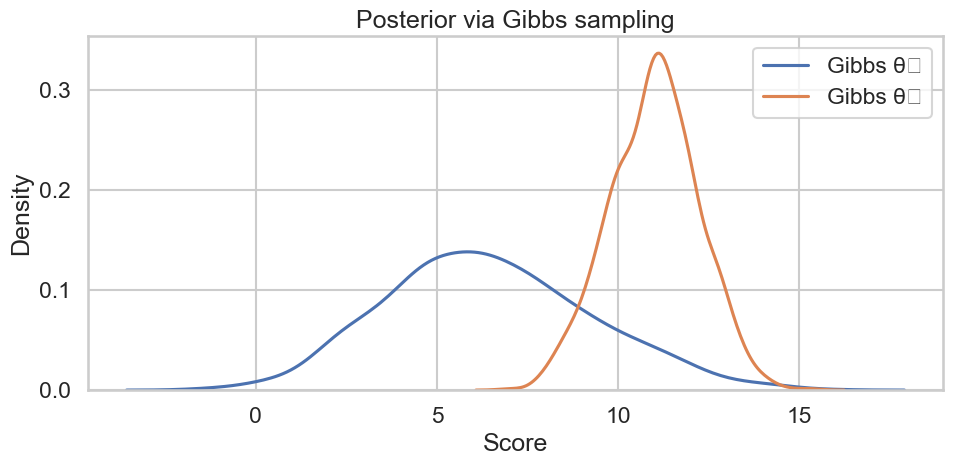

In [12]:
# %%
plt.figure(figsize=(10,5))
sns.kdeplot(theta0_chain, label="Gibbs θ₀")
sns.kdeplot(theta1_chain, label="Gibbs θ₁")
plt.xlabel("Score"); plt.ylabel("Density"); plt.title("Posterior via Gibbs sampling")
plt.legend(); plt.tight_layout(); plt.show()


## Step 5 – Predictive Distribution for 2023
For each Gibbs iteration draw

\[
\tilde y \;=\;
\begin{cases}
\mathcal N(\theta_1,\lambda) & \text{with prob. }0.9, \\
\mathcal N(\theta_0,\lambda) & \text{with prob. }0.1.
\end{cases}
\]


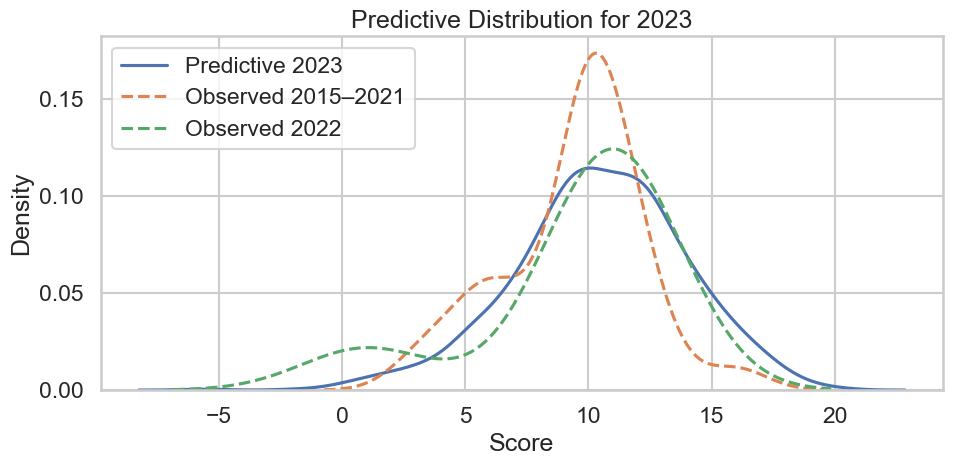

In [13]:
# %%
pred2023 = np.array([
    rng.normal(t1, np.sqrt(lambda_obs)) if rng.random() < p_mixture
    else rng.normal(t0, np.sqrt(lambda_obs))
    for t0, t1 in zip(theta0_chain, theta1_chain)
])

plt.figure(figsize=(10,5))
sns.kdeplot(pred2023,   label="Predictive 2023")
sns.kdeplot(scores,     label="Observed 2015–2021", ls="--")
sns.kdeplot(new_scores, label="Observed 2022",       ls="--")
plt.xlabel("Score"); plt.ylabel("Density")
plt.title("Predictive Distribution for 2023")
plt.legend(); plt.tight_layout(); plt.show()
